<a/ id='top'></a>

# CSCI4022 Homework 4; GMMs

## Due Monday, February 21 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.
- There are two ways to quickly make a .pdf out of this notebook for Gradescope submission.  Either:
 - Use File -> Download as PDF via LaTeX.  This will require your system path find a working install of a TeX compiler
 - Easier: Use File ->  Print Preview, and then Right-Click -> Print using your default browser and "Print to PDF"



---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) |
---


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Theory: GMM; 5 pts) 
In the GMM slides, we stated that the weights $w_m$ of the 1-dimensional GMM with pdf

$f(x|\theta)=w_1\phi(x|\mu_1, \sigma_1^2)+w_2\phi(x|\mu_2, \sigma_2^2)+\dots+ w_m\phi(x|\mu_m, \sigma_m^2)$

required the weights to sum to one.  

#### a) Use the following markdown cell to prove this statement.  In a sentence, describe how this proof might change in higher dimensions.

The weights must add to 1 as the result of this equation is a probability and we cannot have a probability greater than one.

#### b) Is it possible to have a valid pdf $f(x)$ above if any of the weights $w_k$ are negative?  If not, why not?  If so, what other difficulties might be associated with negative weights?

The weights are actually normalized values for the probability that a point belongs to a given cluster. Having a negative weight would make it an invaid pdf and would make it harder to calculate likelyhood.

***

<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (Choose a k? 25 pts)

Continuing with the Pokémon theme of HW3's clustering, we have a data set of geolocated Pokémon Go "spawns" taken from the bay area around San Francisco, CA, US.  What results is a map that should loosely approximate the population density of the San Francisco Bay, with some adjustments according to the weights that Pokémon Go uses (I believe this means more things happen in parks, for example), and some bias due to using cell phone usage as a measure for population location.  The set includes:


`lat`: numeric,	Latitude of spawn

`lng`:	numeric,	Longitude

`name`: which Pokémon spawned at each location (you may discard this if desired).

For all prompts, use Euclidean distance ($L_2$).

(**NB**: using Euclidean distance on lat/lon data is not technically correct, you classically have to *project* locations onto a 2D map or find their true great-circle distances apart.  We will ignore this here, as the region is small enough to have only minor error due to ignoring curvature of the surface.)

Here we will focus on the locational problem of latitude versus longitude.  As in kmeans, instead of choosing $k$ we might choose a variety of values of $k$ and implement a GMM for each.

Shown below is the lat/lon locations of the Pokémon.  Not only is there structure, it has a shape: some data appears in lines that aren't perfect circles.  This is a perfect task for the GMM!

         lat         lng     name
0  37.361151 -122.014794   Cubone
1  37.835080 -122.477904  Spearow
2  37.322755 -121.976948  Rattata


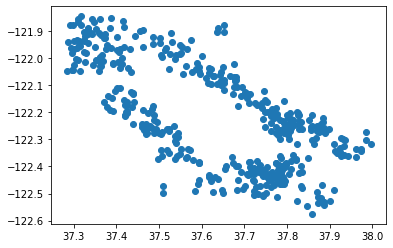

In [2]:
df=pd.read_csv('./data/bayareapokemon.csv', encoding='UTF-8')
print(df.head(3))
plt.scatter(df['lat'], df['lng'])
df=df.drop(columns='name')

**Part A**:  Write (by hand) a function `GMM(dat, k, init=...)` that performs the EM algorithm for a Gaussian mixture model on a given set of $(X,Y)$ locational data.  You may include random initialization inside the function or as an input.

You should run the algorithm for sufficient steps until convergence, and should return at a minimum, the means, 2x2 covariance matrices, and mixture probabilities of each component.  You may also want to return the responsibilities of each datum to the k components for later use, but this is less necessary.

In [50]:
def GMM(dat, k):
    p_class = np.full(k,1/k)
    means = dat.sample(k).to_numpy()
    p_class_given_data = np.zeros((k,len(dat)))
    covars = np.empty((k,2,2))
    mean_dist = .5
    mean_dist_prev=1
    for i in range(k):
        covars[i][0][0]=np.sum((dat.iloc[:,0]-means[i][0])**2/(len(dat)))
        covars[i][1][1]=np.sum((dat.iloc[:,1]-means[i][1])**2/(len(dat)))
        covar12=np.sum(((dat.iloc[:,0]-means[i][0])*(dat.iloc[:,1]-means[i][1])))/(len(dat))
        covars[i][1][0]=covar12
        covars[i][0][1]=covar12#initial covar calc
    while mean_dist_prev-mean_dist> .0001:
        summ = 0
        mean_dist_prev = mean_dist
        mean_dist = 0
        for i in range(k):
            for j in range(len(dat)):
                p_class_given_data[i][j] = (stats.multivariate_normal.pdf(dat.iloc[j], mean=means[i], cov=covars[i]))*p_class[i]
            summ+=p_class_given_data[i]
        for i in range(k):
            p_class_given_data[i] = p_class_given_data[i]/summ
            class_sum = np.sum(p_class_given_data[i])
            p_class[i] =  class_sum/len(dat)

            means[i][0] = (1/class_sum)*np.sum(p_class_given_data[i]*df.iloc[:,0])
            means[i][1] = (1/class_sum)*np.sum(p_class_given_data[i]*df.iloc[:,1])

            covars[i]= np.sum(p_class_given_data[i][l]*np.outer(dat.iloc[l,:]-means[i],dat.iloc[l,:]-means[i]) for l in range(len(dat)))/(len(dat))
            mean_dist+=np.sum([p_class_given_data[i][j]*(((dat.iloc[j,0]-means[i][0])+(dat.iloc[j,1]-means[i][1]))**2) for j in range(len(dat))])
        mean_dist = np.sqrt(mean_dist/len(dat))
    return p_class_given_data, means, covars, p_class, mean_dist

**Part B**: 

Run your algorithm for $k=[1,2,3,4,5,6,7,8]$, then create an **elbow plot** of the weighted-mean-distance to component for each choice of $k$.

To compute this, take a clustering and its responsibilities $p_{mi}$, then compute the average distance between each point and each cluster, weighted by $p_{mi}$:

$$ \bar{D} = \sqrt{\frac{\sum^n_{i=1}\sum^k_{m=1} p_{mi} (x_i-\mu_m)^2}{n}}$$

(**Idea**: this averages the distance between each point and the 'closest' cluster, but allows for the soft-clustering nature of points to compute distances between multiple clusters.)


Create your elbow plot by making a line plot of the values of $\bar{D}$ against $k$.

In [51]:
mean_dist_elbow = np.zeros(8)
p_class_given_dataArr = []
meansArr = []
covarsArr = []
p_classArr = []
mean_distArr = []
for i in range(1,9):
    print(i)
    p_class_given_data, means, covars, p_class, mean_dist = GMM(df,i)
    p_class_given_dataArr.append(p_class_given_data)
    meansArr.append(means)
    covarsArr.append(covars)
    p_classArr.append(p_class)
    mean_distArr.append(mean_dist)

1


C:\Users\caleb\AppData\Local\Temp/ipykernel_22472/437851702.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  covars[i]= np.sum(p_class_given_data[i][l]*np.outer(dat.iloc[l,:]-means[i],dat.iloc[l,:]-means[i]) for l in range(len(dat)))/(len(dat))


2
3
4
5
6
7
8


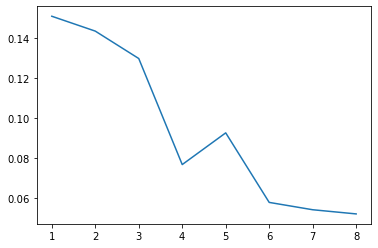

In [52]:
plt.plot([1,2,3,4,5,6,7,8],mean_distArr)

**Part C**: 

Based on the plot in part **B**, what looks like the best choice of $k$ for this problem?  Are multiple values in contention?  Explain, and then plot your preferred choice of $k$ where you color each data point according to the cluster with which it has the highest responsibility (i.e. hard cluster based on responsibilities).

A k of 8 appears to be the best option although 6 and 7 are close as well

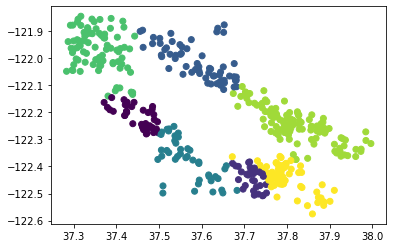

In [54]:
cluster = np.empty(450)
for j in range(len(df)):
    maxVal = float("-inf")
    for i in range(8):
        if p_class_given_dataArr[7][i][j] > maxVal:
            maxVal = p_class_given_dataArr[7][i][j]
            cluster[j] = i
plt.scatter(df["lat"],df["lng"], c=cluster)

***
<a/ id='p3'></a>
[Back to top](#top)
# Problem 3 (Simulation on the GMM; 15 pts)


Because the GMM is a *generative* model, we could use our results from Problem 2 to not only score models based on their mean-distance-to-centroid (or other statistical measures like AIC, BIC), we could simulate points from the models and visually ascertain whether or not they appear similar to the original distribution.

**Part A**: 

For each of the GMM models in Problem 2 from $k=[2,3,4,5,6,7,8]$, simulate 1000 points from your estimated density function (recall: this is a two-part simulation of choosing a component **then** drawing from the normal of appropriate mean/covariance).

Create a figure with 2 columns and 4 rows holding all 8 data sets: the 7 simulated ones and the original data shown above.  Label each plot appropriately.  

In [55]:
data = np.zeros((7,1000,2))
for i in range(2,9):
    choices = np.arange(i)
    for x in range(1000):
        delta = np.random.choice(choices, p=p_classArr[i-1])
        data[i-2][x][0],data[i-2][x][1]=np.random.multivariate_normal(meansArr[i-1][delta],covarsArr[i-1][delta])

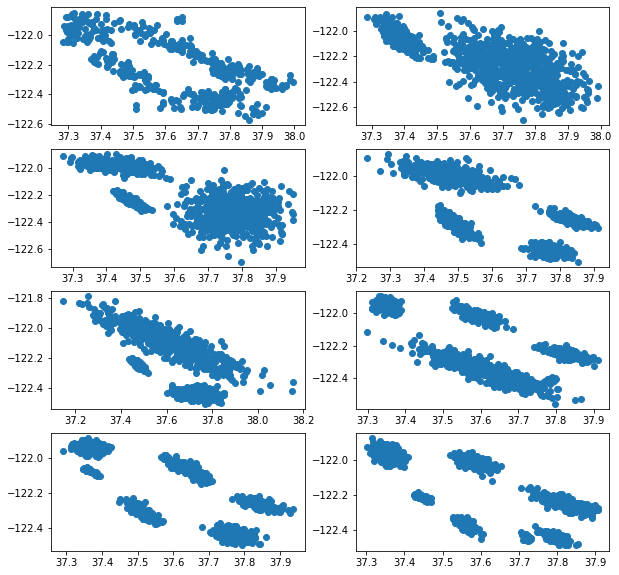

In [56]:
fig,((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ax0.scatter(df["lat"],df["lng"])
ax1.scatter(data[0,:,0],data[0,:,1])
ax2.scatter(data[1,:,0],data[1,:,1])
ax3.scatter(data[2,:,0],data[2,:,1])
ax4.scatter(data[3,:,0],data[3,:,1])
ax5.scatter(data[4,:,0],data[4,:,1])
ax6.scatter(data[5,:,0],data[5,:,1])
ax7.scatter(data[6,:,0],data[6,:,1])

**Part B**: 


Which plot or plots look closest to the original data?  Depending on your interpretations of the elbow plot versus the simulated data, you may have decided that we wanted a different value of $k$ for the best model to *simulate* from rather than the best model to *cluster* or classify upon.  Do you think that this is normally the case?  Why or why not?  What properties of a data set would make one task easier or harder with more or less $k$?

The data set in graph 6 (3 down left side) looks the closest. I could see this being the case as smaller numbers of clusters might create more outliers that better represent a natural data set. Larger numbers of clusters reduce outliers and create simulated data thats clustered tighter.